### Imports

In [1]:
import os
path = os.getcwd()
if path.split(sep="\\")[-1]!='InternshipMatakos':
    os.chdir("..")

from functools import partial

from src import evaluate
from src.evaluate import evaluate_regr
import src.utils
from src.utils import util
from src.utils import data_loaders
from src.utils.domain_split import hyperplane_split
from src.utils.domain_split import hypersphere_split
from src.train_test import fit_regr
from src.train_test import test_regr
from src.model import MLP

import pandas as pd
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.distributions.normal import Normal as norm
import torchmetrics as tm
import pyro
import pyro.distributions as dist
import tyxe

# seed = np.random.randint(10000)
seed = 7141 #4092
np.random.seed(seed)
torch.manual_seed(seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Read airfoil data

In [2]:
df = pd.read_csv("data/regression/airfoil.csv")
df.head()

,Frequency,AngleAttack,ChordLength,FreeStreamVelocity,SuctionSide,Sound
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


### Separate to in-domain / OOD data with a hyperplane

In [3]:
D = df.values

dom_idx, OOD_idx = hyperplane_split(D, OOD_size=0.2, verbose=1, seed=seed)

df[dom_idx].head()

Found random direction n = [ 0.13666669 -0.21046149  0.37092866  0.44570104 -0.43332977 -0.64266321]
Found split with ratio r = 0.20093147039254824


,Frequency,AngleAttack,ChordLength,FreeStreamVelocity,SuctionSide,Sound
0,800,0.0,0.3048,71.3,0.002663,126.201
1,1000,0.0,0.3048,71.3,0.002663,125.201
2,1250,0.0,0.3048,71.3,0.002663,125.951
3,1600,0.0,0.3048,71.3,0.002663,127.591
4,2000,0.0,0.3048,71.3,0.002663,127.461


### We continue the training / testing pipeline with in-domain data only

In [4]:
# Minmax scaling for better network performace
scaler = MinMaxScaler()
D = df[dom_idx].values
D = scaler.fit_transform(D)

# Split in-domain data to data and labels
X, y = D[:,:-1], D[:,-1]

# Split to train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Separate OOD data
OOD = df[OOD_idx].values
OOD = scaler.transform(OOD)         # need to also transform it to be compatible with the NN.
X_OOD, y_OOD = OOD[:,:-1], OOD[:,-1]

### Set network and batch size hyperparameters

In [5]:
# Hyperparameters
n_features = X_train.shape[1]
n_hidden_1 = 100
n_hidden_2 = 30
n_epochs = 1000
learning_rate = 0.0001
weight_decay = 1e-5
batch_size_train = 64
batch_size_test = 64

### Prepare tensor dataset and loaders to pytorch format

In [6]:
# Transformation required for regression problem
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
y_OOD = y_OOD.reshape(-1, 1)

# Tensor datasets
train_dataset = data_loaders.create_torch_dataset(X_train, y_train, to_LongTensor=False)
test_dataset = data_loaders.create_torch_dataset(X_test, y_test, to_LongTensor=False)
OOD_dataset = data_loaders.create_torch_dataset(X_OOD, y_OOD, to_LongTensor=False)

# Data loaders on gpu
train_loader = data_loaders.create_loader(train_dataset, batch_size_train, device)
test_loader = data_loaders.create_loader(test_dataset, batch_size_test, device)
OOD_loader = data_loaders.create_loader(OOD_dataset, batch_size_test, device)

### Model setup

Two hidden layers with 30 neurons and relu activation seems to work well.

In [9]:
airfoil_model = MLP(n_features, 1, [n_hidden_1, n_hidden_2], 'tanh').to(device)
loss_function = nn.MSELoss()
optimizer = optim.Adam(airfoil_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [10]:
# Train
train_losses = fit_regr(airfoil_model, loss_function, optimizer, train_loader, 
    n_epochs=n_epochs, verbose=0, early_stopping='dev', return_losses=True)
avg_train_loss = train_losses[-1]

print(f"Average Train MSE: {avg_train_loss:.5f}")    

Average Train MSE: 0.00023


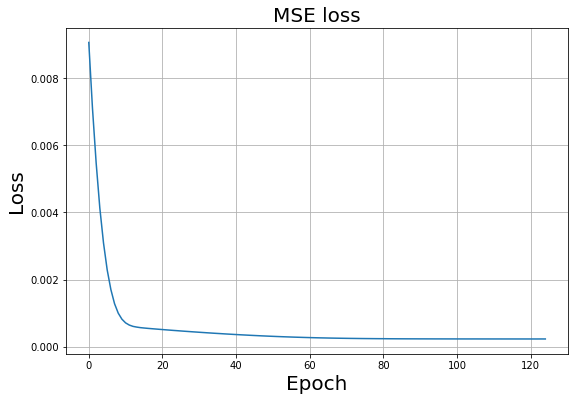

In [11]:
plt.figure(figsize=(9,6))
plt.plot(train_losses)
plt.grid()
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.title("MSE loss", fontsize=20)
plt.show()

In [12]:
avg_test_loss = test_regr(airfoil_model, loss_function, test_loader, verbose=1, return_loss=True)

print(f"Average test MSE = {avg_test_loss:.5f}")   

Average Test MSE Loss: 0.00023977
Average test MSE = 0.00024


### Test on OOD data

In [13]:
avg_OOD_loss = test_regr(airfoil_model, loss_function, OOD_loader, verbose=1, return_loss=True)

print(f"Average OOD loss = {avg_OOD_loss:.10f}")  
print(f"Average OOD loss to train loss ratio: {avg_OOD_loss / avg_train_loss : .3f}")
print(f"Average OOD loss to test loss ratio: {avg_OOD_loss / avg_test_loss : .3f}")

Average Test MSE Loss: 0.00081367
Average OOD loss = 0.0008136718
Average OOD loss to train loss ratio:  3.572
Average OOD loss to test loss ratio:  3.394


### Now that we have a pipeline ready, let's use 10-fold cross validation to see the performance on the whole data

In [13]:
def pipeline(X_train, X_test, y_train, y_test, verbose=0):
    
    # Transformation required for regression problem
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)

    # Tensor datasets
    train_dataset = data_loaders.create_torch_dataset(X_train, y_train, to_LongTensor=False)
    test_dataset = data_loaders.create_torch_dataset(X_test, y_test, to_LongTensor=False)

    # Data loaders on gpu
    train_loader = data_loaders.create_loader(train_dataset, batch_size_train, 'cuda')
    test_loader = data_loaders.create_loader(test_dataset, batch_size_test, 'cuda')

    # Model setup
    # airfoil_model = model.airfoil_NN(n_features, n_hidden_1, n_hidden_2).to(device)
    # airfoil_model = model.airfoil_DNN(n_features, 512, 256, 128, 3).to(device)
    airfoil_model = model.airfoil_laplace(n_features, n_hidden_1, n_hidden_2).to(device)

    loss_function = nn.MSELoss()
    optimizer = optim.Adam(airfoil_model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # fit function optionally returns a list with the epoch-wise losses
    train_loss = fit_regr(airfoil_model, loss_function, optimizer, train_loader, 
                 n_epochs=n_epochs, verbose=0, early_stopping=True, return_loss=True) 
    test_loss = test_regr(airfoil_model, loss_function, test_loader, verbose=0, return_loss=True) 
    
    if verbose:
        print(f"Average Train MSE Loss: {train_loss[-1] : .10f}")
        print(f"Average Test MSE Loss : {test_loss : .10f}" )

    return train_loss, test_loss                 # train loss is a list, test loss is a float
 


Training on fold no. 1
Total train loss for this fold:  0.060322
Average Train MSE Loss:  0.0000558535
Total test loss for this fold:  0.006125
Average Test MSE Loss :  0.0000506175

Training on fold no. 2
Total train loss for this fold:  0.075091
Average Train MSE Loss:  0.0000694645
Total test loss for this fold:  0.008041
Average Test MSE Loss :  0.0000670086

Training on fold no. 3
Total train loss for this fold:  0.063353
Average Train MSE Loss:  0.0000586061
Total test loss for this fold:  0.011064
Average Test MSE Loss :  0.0000921963

Training on fold no. 4
Loss has stopped decreasing after epoch 968 (average of 50 epochs).
STOPPING EARLY.
Total train loss for this fold:  0.065641
Average Train MSE Loss:  0.0000607224
Total test loss for this fold:  0.011564
Average Test MSE Loss :  0.0000963707

Training on fold no. 5
Total train loss for this fold:  0.080948
Average Train MSE Loss:  0.0000748823
Total test loss for this fold:  0.011497
Average Test MSE Loss :  0.0000958044



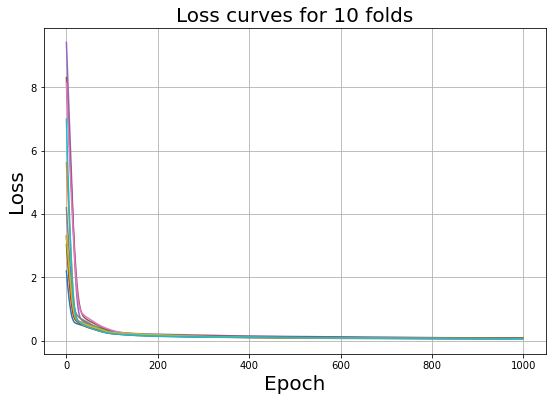

In [14]:
n_splits = 10
kf = KFold(n_splits)

train_losses = np.zeros(n_splits)
test_losses = np.zeros(n_splits)
train_losses_plot = []                           # for plotting loss curves
for i, (train_index, test_index) in enumerate(kf.split(X)):
    
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    print("\nTraining on fold no. %d" %(i+1))
    epoch_wise_train_losses, test_losses[i] = pipeline(X_train, X_test, y_train, y_test, verbose=1)
    train_losses[i] = epoch_wise_train_losses[-1]
    train_losses_plot.append(epoch_wise_train_losses)
    
print("Train losses:", train_losses)
print("Test losses:", test_losses)

avg_train_loss_k_folds = train_losses.mean() / len(X_train)
avg_test_loss_k_folds = test_losses.mean() / len(X_test)
print(f"\nAvg train loss over all folds: {avg_train_loss_k_folds :.5f}")
print(f"Avg test loss over all folds: {avg_test_loss_k_folds :.5f}")

plt.figure(figsize=(9,6))
for losses in train_losses_plot:
    plt.plot(losses)
plt.grid()
plt.xlabel("Epoch", fontsize=20)
plt.ylabel("Loss", fontsize=20)
plt.title(f"Loss curves for {n_splits} folds", fontsize=20)
plt.show()

### Test on OOD data

In [15]:
OOD_loss = test_regr(airfoil_model, loss_function, OOD_loader, verbose=1, return_loss=True)
avg_OOD_loss = OOD_loss / len(X_OOD)

print(f"Average OOD loss = {avg_OOD_loss:.10f}")  
print(f"Average OOD loss to train loss ratio: {avg_OOD_loss / avg_train_loss_k_folds : .3f}")
print(f"Average OOD loss to test loss ratio: {avg_OOD_loss / avg_test_loss_k_folds : .3f}")

Average Test MSE Loss: 0.0003392490009401018
Average OOD loss = 0.0003392490
Average OOD loss to train loss ratio:  4.978
Average OOD loss to test loss ratio:  2.389


### We see that the loss on OOD data is higher, which is a good sign for the domain splitting method.

## Now for the Bayesian treatment

In [15]:
# Model 
net = MLP(n_features, 1, [n_hidden_1, n_hidden_2], 'tanh').to(device)

prior = tyxe.priors.IIDPrior(dist.Normal(
        torch.tensor(0, device=device, dtype=torch.float),
        torch.tensor(1, device=device, dtype=torch.float)))
prior_name = ", IID prior"
likelihood = tyxe.likelihoods.HomoskedasticGaussian(len(X_train), scale=1e-2)
likelihood_name = ", Homoskedastic Gaussian likelihood"
kernel = partial(pyro.infer.mcmc.HMC, step_size=1e-3, num_steps=20, target_accept_prob=0.7)
kernel_name = "HMC"
bnn = tyxe.bnn.MCMC_BNN(net, prior, likelihood, kernel)
bnn.name = kernel_name + ", MCMC BNN" + likelihood_name + prior_name

# Fit
pyro.clear_param_store()
bnn.fit(train_loader, 1000, warmup_steps=500)

Warmup:   0%|                                          | 1/1500 [00:01,  1.96s/it, step size=1.08e-03, acc. prob=1.000]

ValueError: Error while computing log_prob_sum at site 'layer_0.weight':
Expected value argument (Tensor of shape (100, 5)) to be within the support (Real()) of the distribution Normal(loc: torch.Size([100, 5]), scale: torch.Size([100, 5])), but found invalid values:
tensor([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]], device='cuda:0', requires_grad=True)
      Trace Shapes:        
       Param Sites:        
      Sample Sites:        
layer_0.weight dist | 100 5
              value | 100 5


### We evaluate the model on train, test and OOD data.

In [18]:
posterior_samples = 10000

# Train
train_evaluation = evaluate_regr(bnn, train_loader, loss_function, posterior_samples=posterior_samples, rounded=10,
                           dataset="airfoil, Train data", device='cuda')
test_evaluation = evaluate_regr(bnn, test_loader, loss_function, posterior_samples=posterior_samples, rounded=10,
                           dataset="airfoil, Test data", device='cuda')
OOD_evaluation = evaluate_regr(bnn, OOD_loader, loss_function, posterior_samples=posterior_samples, rounded=10,
                           dataset="airfoil, OOD data", device='cuda')

print("Train evaluation:")
for key,  value in train_evaluation.items():
    print(key + str(":"), value)
print("\nTest evaluation:")
for key,  value in test_evaluation.items():
    print(key + str(":"), value)
print("\nOOD evaluation:")
for key,  value in OOD_evaluation.items():
    print(key + str(":"), value)

Train evaluation:
Inference type: HMC, MCMC BNN, Homoskedastic Gaussian likelihood, IID prior
Evaluated on: airfoil, Train data
Number of posterior samples: 10000
Average NLPD: -0.9001517
SD of NLPD: 0.7879529
Total NLPD: -864.14557
Average loss: 0.0001516125
Total loss: 0.1455480373
Average standard deviation: 0.100996174

Test evaluation:
Inference type: HMC, MCMC BNN, Homoskedastic Gaussian likelihood, IID prior
Evaluated on: airfoil, Test data
Number of posterior samples: 10000
Average NLPD: -0.8513045
SD of NLPD: 0.8421962
Total NLPD: -205.16437
Average loss: 0.0001795184
Total loss: 0.0432639401
Average standard deviation: 0.10191046

OOD evaluation:
Inference type: HMC, MCMC BNN, Homoskedastic Gaussian likelihood, IID prior
Evaluated on: airfoil, OOD data
Number of posterior samples: 10000
Average NLPD: 13.818812
SD of NLPD: 67.7841
Total NLPD: 4173.2812
Average loss: 0.0158783523
Total loss: 4.7952623963
Average standard deviation: 0.12639904


### Variational inference


In [19]:
# Only run this to select new domain split

def reset():
    # Data
    dom_idx, OOD_idx = hyperplane_split(df.values, OOD_size=0.2, verbose=1)

    # Minmax scaling for better network performace
    scaler = MinMaxScaler()
    D = df[dom_idx].values
    D = scaler.fit_transform(D)

    # Split in-domain data to data and labels
    X, y = D[:,:-1], D[:,-1]

    # Split to train/test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)#, random_state=42)

    # Separate OOD data
    OOD = df[OOD_idx].values
    OOD = scaler.transform(OOD)         # need to also transform it to be compatible with the NN.
    X_OOD, y_OOD = OOD[:,:-1], OOD[:,-1]

    # Split to train / test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)#, random_state=42)

    # Transformation required for regression problem
    y_train = y_train.reshape(-1, 1)
    y_test = y_test.reshape(-1, 1)
    y_OOD = y_OOD.reshape(-1, 1)

    # Tensor datasets
    train_dataset = data_loaders.create_torch_dataset(X_train, y_train, to_LongTensor=False)
    test_dataset = data_loaders.create_torch_dataset(X_test, y_test, to_LongTensor=False)
    OOD_dataset = data_loaders.create_torch_dataset(X_OOD, y_OOD, to_LongTensor=False)

    # Data loaders on gpu
    train_loader = data_loaders.create_loader(train_dataset, batch_size_train, device)
    test_loader = data_loaders.create_loader(test_dataset, batch_size_test, device)
    OOD_loader = data_loaders.create_loader(OOD_dataset, batch_size_test, device)
    
    pass

# reset()

In [12]:
train_size = len(X_train)
test_size = len(X_test)

# Model 
var_net = MLP(n_features, 1, [n_hidden_1, n_hidden_2], 'relu').to(device)
prior = tyxe.priors.IIDPrior(
    dist.Normal(
        torch.tensor(0, device=device, dtype=torch.float),
        torch.tensor(1, device=device, dtype=torch.float),
    ),
)
prior_name = ", IID prior"
obs_model = tyxe.likelihoods.HomoskedasticGaussian(train_size, scale=0.1)
likelihood_name = ", Homoskedastic Gaussian likelihood"
guide_builder = partial(tyxe.guides.AutoNormal, init_scale=0.01)
guide_name = "Mean field"
var_bnn = tyxe.VariationalBNN(var_net, prior, obs_model, guide_builder)
var_bnn.name = guide_name + " Variational BNN" + likelihood_name + prior_name

In [11]:
# Fit
n_epochs = 30
pyro.clear_param_store()
optim = pyro.optim.Adam({"lr": 1e-3})
elbos = []    
def callback(bnn, i, e):
    elbos.append(e)
var_bnn.fit(train_loader, optim, n_epochs, callback, device=device)

KeyboardInterrupt: 

In [24]:
posterior_samples = 500

# Train
train_evaluation = evaluate_regr(var_bnn, train_loader, loss_function, posterior_samples=posterior_samples, rounded=10,
                           dataset="airfoil, Train data", device=device)
test_evaluation = evaluate_regr(var_bnn, test_loader, loss_function, posterior_samples=posterior_samples, rounded=10,
                           dataset="airfoil, Test data", device=device)
OOD_evaluation = evaluate_regr(var_bnn, OOD_loader, loss_function, posterior_samples=posterior_samples, rounded=10,
                           dataset="airfoil, OOD data", device=device)

print("Train evaluation:")
for key,  value in train_evaluation.items():
    print(key + str(":"), value)
print("\nTest evaluation:")
for key,  value in test_evaluation.items():
    print(key + str(":"), value)
print("\nOOD evaluation:")
for key,  value in OOD_evaluation.items():
    print(key + str(":"), value)

Train evaluation:
Inference type: Mean field Variational BNN, Categorical likelihood, IID prior
Evaluated on: airfoil, Train data
Number of posterior samples: 500
Average NLPD: -1.0756485
SD of NLPD: 0.287691
Total NLPD: -1032.6226
Average loss: 7.12993e-05
Total loss: 0.0684473405
Average standard deviation: 0.114498064

Test evaluation:
Inference type: Mean field Variational BNN, Categorical likelihood, IID prior
Evaluated on: airfoil, Test data
Number of posterior samples: 500
Average NLPD: -1.0624819
SD of NLPD: 0.26488808
Total NLPD: -256.0581
Average loss: 7.75138e-05
Total loss: 0.0186808212
Average standard deviation: 0.11554735

OOD evaluation:
Inference type: Mean field Variational BNN, Categorical likelihood, IID prior
Evaluated on: airfoil, OOD data
Number of posterior samples: 500
Average NLPD: 0.09301762
SD of NLPD: 1.6284838
Total NLPD: 28.091322
Average loss: 0.0006474491
Total loss: 0.1955296285
Average standard deviation: 0.12137825


# Draft below

In [25]:
X_ood, y_ood = data_loaders.separate_torch_dataset(OOD_dataset, device=device)

var_bnn.evaluate(X_ood, y_ood, posterior_samples, reduction='mean')

(tensor(0., device='cuda:0'), tensor(416.4776, device='cuda:0'))

In the case of **Homoskedastic Gaussian** likelihood:

Instead of calculating the likelihood for each test point
$$ p(y_{test} | x_{test}, \theta_t) = N ( f_{\theta} (x_{test}), sd) $$
and then doing Bayesian model averaging
$$ p ( y_{test} | x_{test}, \theta) = \frac{1}{T} \sum_t p(y_{test} | x_{test}, \theta_t), \ \ \ \ \theta_t \sim p(\theta | x,y) \ \ \ \ \ \text{(average over posterior samples)}$$
to then calculate the NLPD
$$ NLPD = -\frac{1}{N} \sum_i \log p(y_i | x_i, \theta), \ \ \ \ \ \text{(average over data)}$$

could we split the data into batches and calculate an average prediction for each batch B:
$$ \bar{y}_{\text{B}} = \frac{1}{|\text{B}|} \sum_{x \in \text{B}} f_{\theta}(x), \ \ \ \ \ \text{B=batch} $$
and then compare against that average value?

That is, for each $(x_{test}, y_{test})$ in batch B, calculate:
$$ p( y_{test} | x_{test}, \theta) = \mathcal{N}( \bar{y}_{\text{B}}, \sigma \text{*}), $$
and then calculate the NLPD as before
$$ NLPD = -\frac{1}{N} \sum_i \log p(y_{test} | x_{test}, \theta). $$


\*where $\sigma$ is the common posterior sd (due to HG assumption)

### you are here

In [16]:
posterior_samples = 32

nllh = torch.empty(0, device='cuda')
for X, target in test_loader:
    
    pred_mean, pred_sd = bnn.predict(X, num_predictions=posterior_samples)
    
    nllh_batch = -1 * norm(pred_mean, pred_sd).log_prob(target)
    nllh = torch.cat((nllh, nllh_batch))
    
nlpd = nllh.mean()
nlpd

tensor(14.1355, device='cuda:0')

In [115]:
NLPD(bnn, train_loader, 1000)
    

(tensor(1.0815, device='cuda:0'),
 tensor(0.1093, device='cuda:0'),
 tensor(1038.2397, device='cuda:0'))

In [33]:
def NLPD_2(
    model, 
    loader, 
    posterior_samples, 
    likelihood = "Homoskedastic Gaussian",   # TODO: obtain this from model, implement other likelihoods
    device='cuda',
    verbose=0,
    ):
    """
    Calculate mean, sd and total NLPD for regression model.
    Used inside evaluate_regr().
    """
    
    if likelihood == "Homoskedastic Gaussian":
        sd = util.posterior_sd(model)
    else:
        raise("This type of likelihood is not impleneted yet.")
        
    # torch tensor with number of posterior samples
    T = torch.tensor(posterior_samples)
    
    NLPD = torch.empty(0, device='cuda')
    with torch.no_grad():
        for data, target in loader:
            # pred is a matrix with dimensions (posterior_samples, batch_size, 1)
            pred = model.predict(data, num_predictions=posterior_samples, aggregate=False)
            
            # warning: heavily vectorized operations ahead!
            if likelihood == "Homoskedastic Gaussian":
                # we transpose pred matrix and vanish the 3rd dimension (it's just 1)
                # resulting matrix is of dimension (batch_size, posterior_samples)
                log_p = norm(pred[:, :, -1].T, sd).log_prob(target)
            else:
                raise("This type of likelihood is not impleneted yet.")
            
            # calculate NLPD
            # log_p is now a matrix, we calculate logsumexp along axis=1
            nlpd = -( torch.logsumexp(log_p, 1) - T.log() )
            NLPD = torch.cat((NLPD, nlpd))

    avg_NLPD = NLPD.mean()
    sd_NLPD = NLPD.std()
    total_NLPD = NLPD.sum()
    
    if verbose==1:
        print("Average NLPD =", avg_NLPD.cpu().detach().numpy())
        print("SD of NLPD =", sd_NLPD.cpu().detach().numpy())
        print("Total NLPD =", total_NLPD.cpu().detach().numpy())
    
    return avg_NLPD, sd_NLPD, total_NLPD

In [ ]:
T = number of posterior samples
B = batch size

nlpd = torch.empty(0, device='cuda')
for X, target in loader:
    
    # pred is a matrix of dimensions (T, B, 1)
    pred_mean = bnn.predict(X, num_predictions=posterior_samples, aggregate=False)
    
    # transpose pred matrix and vanish the 3rd "fake" dimension
    # resulting matrix is of dimension BxT
    pred = pred[:, :, -1].T
    
    # Homoskedastic Gaussian likelihood implies all parameters have a common shared posterior variance
    sd = posterior_sd(bnn)      # flatten all parameters from all posterior samples and calculate the common sd
    
    # Calculate negative log likelihoods (or "log probabilities")
    # nllh is a matrix of dimension BxT
    # (nllh)_ij is the log likelihood of target_i conditioned on output of "posterior" network j with input X_i and the common sd
    nllh = -1 * norm(pred, sd).log_prob(target)     # heavily vectorized pytorch magic
    
    # calculate NLPD
    # logsumexp is calculated along axis 1 (one resulting value for each data point)
    # result is of dimension Bx1
    nlpd_batch = torch.logsumexp(log_p, 1) - T.log()     
    
    nlpd = torch.cat((nlpd, nlpd_batch))
    
avg_nlpd = nlpd.mean()

In [ ]:
# Below is empty space, to allow github scrolling at the bottom